# kaggle: Titanic

Вариант решения для известного соревнования на **kaggle**.

[Ссылка](https://www.kaggle.com/c/titanic) на соревнование.

Импортируем всё необходимое.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.offline import init_notebook_mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

pio.renderers.default = 'notebook'
init_notebook_mode(connected=True)

Загружаем тренировочный и тестовый датасеты.

In [2]:
train_data = pd.read_csv('Путь до файла train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv('Путь до файла test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Сохраним айди пассажиров, для которых нужно будет сделать предсказание. Для удобства также сделаем список с датасетами.

In [4]:
PassengerId = test_data['PassengerId']
full_data = [train_data, test_data]

Посмотрим на основную информацию о датасетах.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Признаки, в которых есть отсутствующие данные: *Age*, *Fare*, *Cabin* и *Embarked*.

Проверим, есть ли в тренировочном датасете дублирующиеся наблюдения.

In [7]:
train_data.duplicated().sum()

0

Займёмся восстановлением пропущенных значений.

Признак *Каюта* (*Cabin*) имеет слишком много пропущенных значений. Скорее всего, он коррелирует с признаком *Класс билета* (*Pclass*), из предположения, что чем ниже класс билета, тем "дальше" от выходов находились каюты, и тем меньше было шансов на спасение у пассажиров.

Изучим признак *Билет* (*Ticket*).

In [8]:
train_data['Ticket'].duplicated().sum()

210

Некоторые билеты имеют одинаковые номера. Наиболее вероятно, что билеты нумеровались по неким правилам, следовательно, по их номерам можно было бы установить некоторые факты о пассажирах. Но всё же значительная часть номеров билетов уникальна, поэтому этот признак мы опустим.

Убираем признаки *Каюта* и *Билет* из датасетов.

In [9]:
for ds in full_data:
    ds.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

Изучим признак *Имя* (*Name*).

In [10]:
train_data['Name'].values[:15]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina'], dtype=object)

Можно заметить, что все записи имеют одинаковый формат: Фамилия, Форма обращения Имя. На основании формы обращения можно установить примерный возраст пассажира, а по фамилии можно будет определять ближайших родственников конкретного пассажира.

Создадим в датасетах новые признаки: *Фамилия* (*Surname*) и *Форма обращения* (*Title*).

In [11]:
for ds in full_data:
    ds['Surname'] = [i[0] for i in ds['Name'].str.split(',')]
    ds['Title'] = [i[1].split('.')[0].lstrip() for i in ds['Name'].str.split(',')]

Посмотрим на все формы обращения, присутствующие в конкретном датасете.

In [12]:
train_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [13]:
test_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

В тестовом датасете присутствует форма, отсутствующая в тренировочном: **Dona** (**Doña**). Это испанская форма обращения **Mrs**, поэтому просто заменим исходную форму аналогом.

In [14]:
test_data['Title'].replace('Dona', 'Mrs', inplace=True)

Установим медианные возрасты в пределах групп, сформированных по форме обращения. Этими значениями будем восстанавливать пропущенные значения признака *Возраст* (*Age*).

Напишем вспомогательную функцию для восстановления пропусков.

In [15]:
def replace_nans(data, feature, group):
    data[feature] = train_data.groupby(group)[feature].apply(lambda x: x.fillna(x.median()))

Восстанавливаем пропуски в *Возрасте*.

In [16]:
for ds in full_data:
    replace_nans(ds, 'Age', 'Title')

Изучим признак *Порт посадки* (*Embarked*).

In [17]:
train_data['Embarked'].value_counts().to_frame().T

,S,C,Q
Embarked,644,168,77


Так как в колонке признака отсутствуют всего лишь 2 значения, просто заменим пропуски самым частотным значением признака.

In [18]:
train_data['Embarked'].fillna('S', inplace=True)

Для тестового датасета в колонке признака *Тариф* (*Fare*) отсутствует одно значение. Так как *Тариф* напрямую связан с *Классом билета*, вычислим медианное значение *Тарифа* для каждого *Класса билета*. Этим значением и восстановим пропуск.

In [19]:
replace_nans(test_data, 'Fare', 'Pclass')

Ещё раз просмотрим информацию о датасетах.

In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
 9   Surname      418 non-null    object 
 10  Title        418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Surname      891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Все пропуски восстановлены. Теперь приступим к EDA.

Как известно, на Титанике руководствовались принципом "Сначала женщины и дети". Посмотрим на распределение количества мужчин по группам "Выжил"-"Погиб" в соответствии с возрастом.

<AxesSubplot:xlabel='Age', ylabel='Density'>

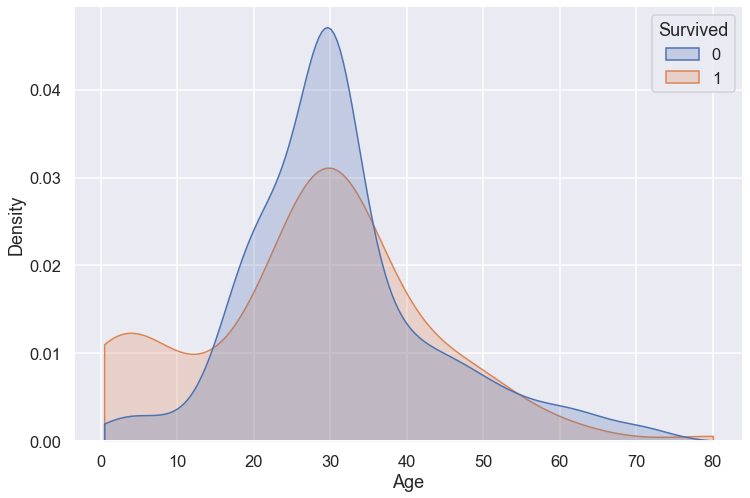

In [22]:
sns.set(rc={'figure.figsize': (12, 8)}, context='talk')
sns.kdeplot(x='Age', data=train_data[train_data['Sex'] == 'male'], hue='Survived',
            clip=(train_data['Age'].min(), train_data['Age'].max()), fill=True, common_norm=False)

Видим, что на графике "выживших" в диапазоне возраста до 10 лет присутствует достаточно большое количество человек. Очевидно, это дети. Форма обращения к детям мужского пола в датасете - **Master**.

Узнаем максимальный возраст для данной формы обращения.

In [23]:
train_data[train_data['Title'] == 'Master']['Age'].max()

12.0

Проверим предположение о том, что чем выше *Класс билета*, тем больше шансов на выживание было у пассажиров.

Напишем вспомогательную функцию для отрисовки графиков.

In [24]:
def plot_barplot(data, feature, value, first_group):
    temp = data[data[feature] == value].groupby([first_group, 'Survived'], as_index=False)['PassengerId'].count()
    temp.rename(columns={'PassengerId': 'Count'}, inplace=True)
    temp['Survived'] = temp['Survived'].astype(str)
    fig = px.bar(temp, x=first_group, y='Count', color='Survived', barmode='group')
    fig.show()

График количества выживших и погибших женщин в зависимости от *Класса билета*.

In [25]:
plot_barplot(train_data, 'Sex', 'female', 'Pclass')

Для женщин предположение более чем подтверждается.

Посмотрим на ситуацию с мужчинами.

In [26]:
plot_barplot(train_data, 'Sex', 'male', 'Pclass')

Учитывая принцип "Сначала женщины и дети", здесь предположение тоже подтверждается.

Проверим предположение, что женщины и дети в рамках одной семьи зачастую либо все выживали, либо все погибали.

In [27]:
all_survived = []
all_deceased = []
combined = []
for surname in pd.unique(train_data['Surname']):
    temp = train_data[((train_data['Title'] == 'Master') | (train_data['Sex'] == 'female')) & (train_data['Surname'] == surname)]
    if len(temp) >= 2 and all(temp['Survived'] == 1):
        all_survived.append(surname)
    elif len(temp) >= 2 and all(temp['Survived'] == 0):
        all_deceased.append(surname)
    elif len(temp) >= 2:
        combined.append(surname)

Список семей, где все женщины и дети выжили.

In [28]:
all_survived

['Johnson',
 'Sandstrom',
 'Fortune',
 'Nicola-Yarred',
 'Laroche',
 'Harper',
 'West',
 'Moubarek',
 'Caldwell',
 'Doling',
 'Peter',
 'Navratil',
 'Goldsmith',
 'Becker',
 'Brown',
 'Newell',
 'Collyer',
 'Murphy',
 'Hamalainen',
 'Taussig',
 'Graham',
 'Mellinger',
 'Kelly',
 'Hays',
 'Ryerson',
 'Hart',
 'Wick',
 'Hippach',
 'Coutts',
 'Richards',
 'Baclini',
 'Quick',
 'Herman',
 'Moor']

Список семей, где все женщины и дети погибли.

In [29]:
all_deceased

['Palsson',
 'Rice',
 'Vander Planke',
 'Panula',
 'Goodwin',
 'Skoog',
 'Ford',
 'Zabour',
 'Jussila',
 'Boulos',
 'Sage',
 'Lefebre',
 'Bourke',
 'Strom',
 'Barbara',
 'Van Impe']

Список семей, где среди женщин и детей есть как выжившие, так и погибшие.

In [30]:
combined

['Andersson', 'Asplund', 'Carter', 'Allison']

Распределение выживших и погибших детей мужского пола по *Классу билета*.

In [31]:
plot_barplot(train_data, 'Title', 'Master', 'Pclass')

Узнаем ценность признака *Embarked*. Рассмотрим зависимость пола пассажиров и их статуса от *Порта посадки*.

Сначала для мужчин.

In [32]:
plot_barplot(train_data, 'Sex', 'male', 'Embarked')

Теперь для женщин.

In [33]:
plot_barplot(train_data, 'Sex', 'female', 'Embarked')

При такой группировке пассажиров, общий тренд по-прежнему сохраняется - мужчины погибали намного чаще женщин. Можно заметить, что взошедшие на борт в **Квинстауне** (**Q**) мужчины практически все погибли, а значительная часть женщин, взошедших на борт в **Шербуре** (**C**), выжила.

Посмотрим на *Классы билетов* пассажиров, взошедших на борт в разных городах.

**Саутгемптон** (**S**)

In [34]:
plot_barplot(train_data, 'Embarked', 'S', 'Pclass')

**Шербур**

In [35]:
plot_barplot(train_data, 'Embarked', 'C', 'Pclass')

**Квинстаун**

In [36]:
plot_barplot(train_data, 'Embarked', 'Q', 'Pclass')

Как мы видим, практически все пассажиры из **Квинстауна** были с билетами **3 класса**, это и объясняет большой процент погибших мужчин из этого города, а большой процент выживших женщин из **Шербура** объясняется тем, что в этом городе их взошло на борт достаточно много по отношению к количеству мужчин оттуда же, а также тем, что абсолютное большинство пассажиров из этого города были с билетами **1 класса**.
Можно заключить, что данный признак малоинформативен.

Объединим оба датасета и создадим следующие признаки:
- *Выживание семьи* (*Family_survival*) со следующими значениями: **1** - если все члены семьи выжили; **0** - если хотя бы один член семьи погиб; **0.5** - если семья состоит из одного человека, либо статус членов семьи неизвестен. Семьёй будем считать однофамильцев в пределах одного *Класса билета*;
- *Количество членов семьи* (*Family_count*), представляющее собой сумму двух других признаков - *Количество братьев/сестёр; наличие супруга* (*SibSp*) и *Количество детей/родителей* (*Parch*).

Для удобства заменим пропуски из тестового датасета в признаке *Выжил* (*Survived*) на **-1**.

In [37]:
df = pd.concat(full_data)
df['Family_survival'] = 0.5
df['Family_count'] = df['SibSp'] + df['Parch']
df['Survived'].fillna(-1, inplace=True)

In [38]:
temp = df.groupby(['Surname', 'Pclass'], as_index=False)['PassengerId'].count().rename(columns={'PassengerId': 'Count'})
temp

,Surname,Pclass,Count
0,Abbing,3,1
1,Abbott,3,3
2,Abelseth,3,2
3,Abelson,2,2
4,Abrahamsson,3,1
...,...,...,...
903,de Mulder,3,1
904,de Pelsmaeker,3,1
905,del Carlo,2,2
906,van Billiard,3,3


In [39]:
for index, observation in df.iterrows():
    for _, series in temp.iterrows():
         if observation['Surname'] == series['Surname'] and observation['Pclass'] == series['Pclass'] and series['Count'] > 1:
                if any((0, 1)) not in df[(df['Surname'] == series['Surname']) & (df['Pclass'] == series['Pclass'])]['Survived'].values:
                    continue
                elif 0 in df[(df['Surname'] == series['Surname']) & (df['Pclass'] == series['Pclass'])]['Survived'].values:
                    df['Family_survival'].iat[index] = 0
                elif 0 not in df[(df['Surname'] == series['Surname']) & (df['Pclass'] == series['Pclass'])]['Survived'].values:
                    df['Family_survival'].iat[index] = 1
df.reset_index(drop=True, inplace=True)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Family_survival,Family_count
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Braund,Mr,0.0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Cumings,Mrs,1.0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Heikkinen,Miss,0.5,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Futrelle,Mrs,0.0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Allen,Mr,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,-1.0,3,"Spector, Mr. Woolf",male,30.0,0,0,0.0000,S,Spector,Mr,0.5,0
1305,1306,-1.0,1,"Oliva y Ocana, Dona. Fermina",female,44.0,0,0,7.9250,C,Oliva y Ocana,Mrs,0.5,0
1306,1307,-1.0,3,"Saether, Mr. Simon Sivertsen",male,35.0,0,0,8.0500,S,Saether,Mr,0.5,0
1307,1308,-1.0,3,"Ware, Mr. Frederick",male,34.0,0,0,32.5000,S,Ware,Mr,0.5,0


Подготовим датасет для машинного обучения. Пройдёмся по признакам:
- *PassengerId* - не несёт в себе никакой информации о целевой переменной;
- *Name* - всю полезную информацию из этого признака мы прежде извлекли в виде признаков *Title* и *Surname*;
- *SibSp* и *Parch* - их мы объединили в признак *Family_count*;
- *Fare* - напрямую связан с *Pclass*;
- *Embarked* - как мы выяснили до этого, данный признак малоинформативен;
- *Surname* - информацию из этого признака мы использовали для *Family_survival*;
- Несмотря на то, что *Title* сильно коррелирует с *Age* и *Sex*, этот признак мы оставим, т.к. некоторые его значения являются титулами, т.е. определяют человека с высоким социальным статусом, что явно повышает его шансы на выживание.

Обновляем датасет.

In [40]:
df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Surname'], axis=1, inplace=True)
df

,Survived,Pclass,Sex,Age,Title,Family_survival,Family_count
0,0.0,3,male,22.0,Mr,0.0,1
1,1.0,1,female,38.0,Mrs,1.0,1
2,1.0,3,female,26.0,Miss,0.5,0
3,1.0,1,female,35.0,Mrs,0.0,1
4,0.0,3,male,35.0,Mr,1.0,0
...,...,...,...,...,...,...,...
1304,-1.0,3,male,30.0,Mr,0.5,0
1305,-1.0,1,female,44.0,Mrs,0.5,0
1306,-1.0,3,male,35.0,Mr,0.5,0
1307,-1.0,3,male,34.0,Mr,0.5,0


Значения признака *Pclass* по сути представляют собой категории, поэтому произведём их конверсию из чисел. Для краткости также закодируем *Пол* (*Sex*) в бинарном виде.

Все категориальные признаки кодируем методом ***One-Hot***.

In [41]:
df['Pclass'] = df['Pclass'].astype(str)
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df = pd.get_dummies(df)
df

,Survived,Sex,Age,Family_survival,Family_count,Pclass_1,Pclass_2,Pclass_3,Title_Capt,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
0,0.0,1,22.0,0.0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1.0,0,38.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.0,0,26.0,0.5,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1.0,0,35.0,0.0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,1,35.0,1.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,-1.0,1,30.0,0.5,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1305,-1.0,0,44.0,0.5,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1306,-1.0,1,35.0,0.5,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1307,-1.0,1,34.0,0.5,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Обратно разделяем датасет на трейн и тест.

In [42]:
train = df[df['Survived'] != -1]
test = df[df['Survived'] == -1].drop('Survived', axis=1)

Посмотрим на соотношение классов целевой переменной.

In [43]:
train['Survived'].value_counts(normalize=True).to_frame().T

,0.0,1.0
Survived,0.616162,0.383838


Явного дисбаланса классов нет, поэтому не будем прибегать к методам их балансировки.

Так как наблюдений в датасете довольно мало, производить кросс-валидацию не будем и ограничимся отложенной выборкой.

In [44]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('Survived', axis=1), train['Survived'], test_size=0.2,
                                                 stratify=train['Survived'], random_state=42)
X_test = test

Обучим модели случайного леса и градиентного бустинга и сравним их **accuracy**.

In [45]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [46]:
print(f'Accuracy случайного леса: {accuracy_score(y_val, rf.predict(X_val))}')

Accuracy случайного леса: 0.8379888268156425


In [47]:
xc = xgb.XGBClassifier(n_estimators=500, use_label_encoder=False, max_depth=5, eta=0.1, n_jobs=-1, random_state=42,
                      colsample_bytree=np.sqrt(len(X_train.columns))/len(X_train.columns))
xc.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='error', early_stopping_rounds=100, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.20412414523193148, eta=0.1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [48]:
print(f'Accuracy градиентного бустинга: {accuracy_score(y_val, xc.predict(X_val))}')

Accuracy градиентного бустинга: 0.8659217877094972


Градиентный бустинг показал лучшие результаты, значит его и будем использовать для предсказаний в тестовом датасете.

In [49]:
decision = pd.DataFrame({'PassengerId': PassengerId, 'Survived': xc.predict(X_test)})
decision

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Сохраняем предсказания.

In [50]:
decision.to_csv('Путь для сохранения и название файла', index=False)